#  KenKen (KenDoku) Puzzle Solver using the Backtracking Search Algorithm AND a Genetic Algorithm.

In [1]:
import random
import math
import numpy as np
import ast
import ipywidgets as widgets
from IPython.display import display, clear_output
import time
import matplotlib.pyplot as plt

| Module                      | Purpose                                                                                                                                  |
| --------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------- |
| `random`                    | Used for random operations (e.g., initializing populations, mutations in Genetic Algorithms).                                            |
| `math`                      | Provides mathematical functions like `sqrt`, `log`, etc., essential for computing fitness or other metrics.                              |
| `numpy` (`np`)              | Enables efficient numerical computations, matrix operations, and data handling. Vital for representing puzzle grids or populations.      |
| `ast`                       | Safely evaluates strings (e.g., user-input lists or dictionaries) to Python literals using `ast.literal_eval`.                           |
| `ipywidgets` (`widgets`)    | Adds interactivity to Jupyter Notebooks through dropdowns, sliders, buttons, etc., enhancing user control over the solver.               |
| `IPython.display`           | Functions like `display()` and `clear_output()` enable dynamic interface updates (e.g., clearing old outputs when solving a new puzzle). |
| `time`                      | Used for performance measurement or adding delays to animations (e.g., to visualize solver steps).                                       |
| `matplotlib.pyplot` (`plt`) | For plotting diagrams like fitness curves, solution evolution, or other performance metrics.                                             |


#  KenKen Puzzle Solver (Backtracking)

A Python class to solve KenKen puzzles using the **backtracking algorithm**, supporting both **user input** and **file input** modes.

---

##  Features

* Supports grid sizes **3x3 to 8x8**
* Reads puzzle data from **user** or **file**
* Validates cage definitions (no overlaps, full coverage)
* Solves using **backtracking** with:

  * Row & column uniqueness
  * Cage arithmetic constraints (`+, -, *, /, =`)

---

##  Key Methods

* `__init__()`: Initializes the puzzle from user or file
* `solve()`: Solves and prints the puzzle
* `backtracking()`: Recursive backtracking logic
* `is_valid_assignment()`: Validates placement
* `check_cage()`: Enforces cage arithmetic rules
* `print_solution()`: Displays the grid

In [2]:
class KenkenB:
    def __init__(self, n=None, cages=None):
        self.n = n
        self.grid = [[0]*n for _ in range(n)] if n else []
        self.cages = cages or {}
        self.cellToCageMap = None

        if n and cages:
            self._initialize_puzzle()


    def _initialize_puzzle(self):
        if not self.validateCages():
            raise ValueError("Invalid cage configuration")
        self.cellToCageMap = self.mapCellsToCages()

    def validateCages(self):
        seen = set()
        for cage in self.cages.values():
            for cell in cage['cells']:
                if cell in seen:
                    print(f"Error: Duplicate cell {cell} in cages.")
                    return False
                seen.add(cell)
        return len(seen) == self.n * self.n

    def mapCellsToCages(self):
        cellToCageMap = [[0] * self.n for _ in range(self.n)]
        for cage_id in self.cages:
            for row, col in self.cages[cage_id]['cells']:
                cellToCageMap[row][col] = cage_id
        return cellToCageMap

    def is_valid_assignment(self, row, col, value):
        return all([
            self.check_row(row, value),
            self.check_column(col, value),
            self.check_cage(row, col, value)
        ])

    def check_row(self, row, value):
        return value not in self.grid[row]

    def check_column(self, col, value):
        return all(self.grid[r][col] != value for r in range(self.n))

    def check_cage(self, row, col, value):
        cage_num = self.cellToCageMap[row][col]
        cage = self.cages[cage_num]
        cells = cage['cells']
        op = cage['op']
        target = cage['value']

        values = []
        for r, c in cells:
            if (r, c) == (row, col):
                values.append(value)
            elif self.grid[r][c] != 0:
                values.append(self.grid[r][c])
            else:
                values.append(None)

        filled = [v for v in values if v is not None]

        if op == "=":
            return value == target

        elif op == "+":
            current_sum = sum(filled)
            if None in values:
                return current_sum <= target
            return current_sum == target

        elif op == "*":
            product = 1
            for v in filled:
                product *= v
            if None in values:
                return product <= target
            product = 1
            for v in values:
                if v is None:
                    return True
                product *= v
            return product == target

        elif op == "-":
            if len(values) == 2 and None not in values:
                return abs(values[0] - values[1]) == target
            return True

        elif op == "/":
            if len(values) == 2 and None not in values:
                v1, v2 = values
                return v1 / v2 == target or v2 / v1 == target
            return True

        return False

    def solve(self):
        if self.backtracking():
            print("Puzzle solved:")
            self.print_solution()
        else:
            print("Puzzle unsolvable.")

    def backtracking(self):
        row, col = self.find_empty()
        if row is None:
            return True

        for i in range(1, self.n + 1):
            if self.is_valid_assignment(row, col, i):
                self.grid[row][col] = i
                if self.backtracking():
                    return True
                self.grid[row][col] = 0

        return False

    def find_empty(self):
        for r in range(self.n):
            for c in range(self.n):
                if self.grid[r][c] == 0:
                    return r, c
        return None, None

    def print_solution(self):
        for row in self.grid:
            print(row)

    def getKenkenGrid(self):
        return self.grid

    def getKenkenCagesDict(self):
        return self.cages

    @classmethod
    def from_gui_input(cls, grid_size, cages):
        formatted_cages = {
            i+1: {'op': c[0], 'value': c[1], 'cells': c[2]}
            for i, c in enumerate(cages)
        }
        return cls(n=grid_size, cages=formatted_cages)

# KenKen Genetic Algorithm Solver

This code implements a Genetic Algorithm to solve KenKen puzzles. It includes functions for generating solutions, evaluating fitness based on puzzle constraints, selection, crossover, mutation, and running the overall evolutionary process.

---

## Functions Overview

### `generate_individual(grid_size, seed=None)`

Generates a valid KenKen grid with unique numbers in each row and column.

### `create_population(population_size, grid_size)`

Creates an initial population of valid KenKen grids.

### `calculate_cage_result(cage_values, operation)`

Calculates the result of a cage operation (`+`, `-`, `*`, `/`) on given values.

### `check_uniqueness(solution, grid_size)`

Checks row and column uniqueness violations and returns a penalty score.

### `evaluate_cage(solution, cages)`

Calculates the penalty based on how well the cage values satisfy their target operations.

### `evaluate_fitness(population, grid_size, cages)`

Computes fitness scores (negative penalty) for all individuals in the population.

### `selection(population, fitness_values)`

Selects individuals probabilistically based on their fitness for breeding.

### `crossover(parent1, parent2)`

Performs a single-point row-wise crossover between two parents.

### `uniform_crossover(parent1, parent2, probability=0.5)`

Swaps individual cells between parents with given probability.

### `mutate(solution, pm)`

Randomly mutates cells in a solution with mutation probability `pm`.

### `swap_mutate(solution, pm)`

Randomly swaps values between two cells in the solution with probability `pm`.

### `kenkenG(pop_size, max_generations, grid_size, cages, pm)`

Main Genetic Algorithm loop:

* Initializes population
* Evolves generations through selection, crossover, and mutation
* Tracks and returns the best solution found



## Overview of the Genetic Algorithm
- Initialize a population of random grids.

- Evaluate how good each solution is.

- Select better solutions.

- Crossover (recombine) solutions to create new ones.

- Mutate them randomly.

- Repeat until you find an optimal solution (fitness = 0).

In [3]:
def generate_individual(grid_size, seed=None):
    random.seed(seed)
    while True:
        numbers = list(range(1, grid_size + 1))
        grid = np.zeros((grid_size, grid_size), dtype=int)

        for i in range(grid_size):
            random.shuffle(numbers)
            grid[i] = numbers[:]

        row_duplicates = any(len(np.unique(row)) < grid_size for row in grid)
        col_duplicates = any(len(np.unique(col)) < grid_size for col in grid.T)

        if not (row_duplicates or col_duplicates):
            break

    return grid

def create_population(population_size, grid_size):
    population = [generate_individual(grid_size, seed=i) for i in range(population_size)]
    return population

def calculate_cage_result(cage_values, operation):
    if operation == "+":
        return sum(cage_values)
    elif operation == "-":
        if len(cage_values) < 2:
            return 0
        return abs(cage_values[0] - sum(cage_values[1:]))
    elif operation == "*":
        if len(cage_values) == 0:
            return 0
        result = 1
        for value in cage_values:
            result *= value
        return result
    elif operation == "/":
        if len(cage_values) < 2:
            return 0
        cage_values = sorted(cage_values)
        result = cage_values[-1]
        for value in cage_values[:-1]:
            result /= value
        return math.floor(result)
    else:
        raise ValueError("Unsupported operation: {}".format(operation))


def check_uniqueness(solution, grid_size):
    fitness_penalty = 0

    try:
        grid = solution
        if grid is None or not isinstance(grid, np.ndarray) or grid.shape != (grid_size, grid_size):
            return grid_size

        for i in range(grid_size):
            row_values = set()
            col_values = set()
            for j in range(grid_size):
                value_row = grid[i, j]
                if value_row is None:
                    return grid_size

                if value_row in row_values:
                    fitness_penalty += 1
                row_values.add(value_row)

                value_col = grid[j, i]
                if value_col is None:
                    return grid_size
                if value_col in col_values:
                    fitness_penalty += 1
                col_values.add(value_col)

    except IndexError as e:
        print(f"IndexError: {e}")
        return grid_size

    return fitness_penalty

def evaluate_cage(solution, cages):
    fitness_penalty = 0

    grid = solution

    for operation, target_value, cells in cages:
        valid_cells = [(i, j) for i, j in cells if 0 <= i < len(grid) and 0 <= j < len(grid[0])]

        cage_values = [grid[i][j] for i, j in valid_cells]

        cage_result = calculate_cage_result(cage_values, operation)

        fitness_penalty += abs(target_value - cage_result)

    return int(fitness_penalty)

# The lower the penalty, the better the solution

def evaluate_fitness(population, grid_size, cages):
    fitness_values = []
    for i in range(len(population)):
        uniqueness_penalty = check_uniqueness(population[i], grid_size)
        cage_penalty = evaluate_cage(population[i], cages)

        total_penalty = uniqueness_penalty + cage_penalty

        fitness_values.append(-total_penalty)

    return fitness_values

def selection(population, fitness_values):
    selected_population = []

    total_fitness = sum(fitness_values)

    selection_probabilities = [fitness / total_fitness for fitness in fitness_values]

    for _ in range(len(population)):
        selected = False
        while not selected:
            selected_index = random.choices(range(len(population)), weights=selection_probabilities)[0]

            selected_population.append(population[selected_index])
            selected = True

    return selected_population



def crossover(parent1, parent2):
    grid_size = len(parent1)
    child1 = np.zeros((grid_size, grid_size), dtype=int)
    child2 = np.zeros((grid_size, grid_size), dtype=int)

    crossover_point = random.randint(1, grid_size - 1)

    child1[:crossover_point, :] = parent1[:crossover_point, :]
    child1[crossover_point:, :] = parent2[crossover_point:, :]

    child2[:crossover_point, :] = parent2[:crossover_point, :]
    child2[crossover_point:, :] = parent1[crossover_point:, :]

    return child1, child2


def uniform_crossover(parent1, parent2, probability=0.5):
    grid_size = len(parent1)
    child1 = parent1.copy()
    child2 = parent2.copy()

    for i in range(grid_size):
        for j in range(grid_size):
            if random.random() < probability:
                child1[i][j], child2[i][j] = child2[i][j], child1[i][j]

    return child1, child2



def mutate(solution, pm):
    mutated_solution = solution.copy()

    grid_size = len(solution)

    for i in range(grid_size):
        for j in range(grid_size):
            if random.random() < pm:
                mutated_solution[i][j] = np.random.randint(1, grid_size + 1)

    return mutated_solution


def swap_mutate(solution, pm):
    mutated_solution = solution.copy()
    grid_size = len(solution)

    for _ in range(grid_size):
        if random.random() < pm:
            i, j = random.randint(0, grid_size - 1), random.randint(0, grid_size - 1)
            k, l = random.randint(0, grid_size - 1), random.randint(0, grid_size - 1)

            mutated_solution[i][j], mutated_solution[k][l] = mutated_solution[k][l], mutated_solution[i][j]

    return mutated_solution


def kenkenG(pop_size, max_generations, grid_size, cages, pm):
    population = create_population(pop_size, grid_size)
    best_fitness_overall = None
    best_solution = None

    for i_gen in range(max_generations):
        fitness_values = evaluate_fitness(population, grid_size, cages)
        best_i = fitness_values.index(max(fitness_values))
        best_fitness = fitness_values[best_i]
        best_solution_gen = population[best_i]
        best_solution_gen = np.array(best_solution_gen)

        if best_fitness_overall is None or best_fitness > best_fitness_overall:
            best_fitness_overall = best_fitness
            best_solution = population[best_i]

        population_best_fitness = max(fitness_values)
        print(f'i_gen = {i_gen:06}   Best fitness in population: {-population_best_fitness:03}')
        print(best_solution_gen)
        if best_fitness == 0:
            print('Found optimal solution')
            break

        selected_pop = selection(population, fitness_values)
        children = []

        for i in range(0, len(selected_pop), 2):
            if i + 1 < len(selected_pop):
                child1, child2 = crossover(selected_pop[i], selected_pop[i + 1])
                child1 = swap_mutate(child1, pm)
                child2 = swap_mutate(child2, pm)
                children.append(child1)
                children.append(child2)

        population = children

    print()
    print('Best solution:')
    print(best_solution)
    print('\r' + f' Best fitness={-best_fitness_overall:03}', end='')

    return best_solution

# KenKen Puzzle Solver UI (ipywidgets)

**Features:**

* **Input Mode Toggle:** Switch between preset puzzles and custom cage input.
* **Preset Dropdown:** Choose from predefined KenKen puzzles.
* **Custom Input:** Text area for manual cage definitions.
* **Parameter Sliders:** Adjust grid size, population, generations, and mutation rate.
* **Solve Button:** Runs the genetic algorithm solver.
* **Output Area:** Shows solving status, time, and visualizes the solution grid.

**Key Functions:**

* `plot_grid(grid, title)`: Visualizes the KenKen solution grid.
* `on_solve_click(_)`: Parses input, runs solver, displays results.
* `toggle_input_ui(change)`: Switches UI input widget based on mode.

**Usage:**

1. Select input mode (Preset/Custom).
2. Enter/select cage data.
3. Set solver parameters.
4. Click **Solve KenKen** to see the solution.

# gentic GUI

In [4]:
input_modeG = widgets.ToggleButtons(
    options=['Preset', 'Custom'],
    description='Input Mode:',
    style={'button_width': '80px'}
)

puzzle_presetsG = {
    "4x4 Puzzle A": [
        ('*', 6, [(0, 0), (1, 0)]),
        ('+', 5, [(0, 1), (0, 2)]),
        ('/', 2, [(0, 3), (1, 3)]),
        ('*', 8, [(2, 0), (3, 0), (3, 1)]),
        ('-', 1, [(1, 1), (2, 1)]),
        ('+', 3, [(1, 2), (2, 2)]),
        ('+', 7, [(2, 3), (3, 2), (3, 3)])
    ]
}

preset_dropdownG = widgets.Dropdown(
    options=list(puzzle_presetsG.keys()),
    description='Puzzle:',
    value="4x4 Puzzle A"
)


custom_input_areaG = widgets.Textarea(
    value="""('*', 6, [(0, 0), (1, 0)]),
('+', 5, [(0, 1), (0, 2)]),
('/', 2, [(0, 3), (1, 3)]),
('*', 8, [(2, 0), (3, 0), (3, 1)]),
('-', 1, [(1, 1), (2, 1)]),
('+', 3, [(1, 2), (2, 2)]),
('+', 7, [(2, 3), (3, 2), (3, 3)])""",
    description='Cages Only:',
    layout=widgets.Layout(width='100%', height='180px')
)

grid_size_sliderG = widgets.IntSlider(value=4, min=3, max=6, step=1, description='Grid Size:')
pop_size_sliderG = widgets.IntSlider(value=50, min=10, max=200, step=10, description='Population:')
gens_sliderG = widgets.IntSlider(value=100, min=10, max=500, step=10, description='Generations:')
mut_sliderG = widgets.FloatSlider(value=0.1, min=0.01, max=0.5, step=0.01, description='Mutation Rate:')

solve_buttonG = widgets.Button(description="Solve KenKen", button_style='success')
output_areaG = widgets.Output()


def on_solve_click_G(_):
    with output_areaG:
        clear_output()
        grid_size = grid_size_sliderG.value
        population_size = pop_size_sliderG.value
        generations = gens_sliderG.value
        mutation_rate = mut_sliderG.value

        if input_modeG.value == "Preset":
            cages = puzzle_presetsG[preset_dropdownG.value]
        else:
            raw_input = custom_input_areaG.value.strip()
            try:
                cages = ast.literal_eval(f"[{raw_input}]")
                if not isinstance(cages, list):
                    raise ValueError("Parsed data is not a list.")
            except Exception as e:
                print(" Error parsing cages:\n", str(e))
                return

        print(" Solving KenKen Puzzle using Genetic Algorithm...\n")
        start_time = time.time()

        solution = kenkenG(population_size, generations, grid_size, cages, mutation_rate)

        end_time = time.time()
        print(f"\n Solved in {end_time - start_time:.2f} seconds")
        print(" Solution:\n", solution)

solve_buttonG.on_click(on_solve_click_G)

def toggle_input_ui_G(change):
    if change['new'] == 'Preset':
        input_boxG.children = [preset_dropdownG]
    else:
        input_boxG.children = [custom_input_areaG]

input_modeG.observe(toggle_input_ui_G, names='value')
input_boxG = widgets.VBox([preset_dropdownG])


uiG = widgets.VBox([
    input_modeG,
    input_boxG,
    grid_size_sliderG,
    pop_size_sliderG,
    gens_sliderG,
    mut_sliderG,
    solve_buttonG,
    output_areaG
])

# backtracking GUI

In [5]:
input_mode = widgets.ToggleButtons(
    options=['Preset', 'Custom'],
    description='Input Mode:',
    style={'button_width': '100px'}
)

puzzle_presets = {
    "4x4 Puzzle A": [
        ('*', 6, [(0, 0), (1, 0)]),
        ('+', 5, [(0, 1), (0, 2)]),
        ('/', 2, [(0, 3), (1, 3)]),
        ('*', 8, [(2, 0), (3, 0), (3, 1)]),
        ('-', 1, [(1, 1), (2, 1)]),
        ('+', 3, [(1, 2), (2, 2)]),
        ('+', 7, [(2, 3), (3, 2), (3, 3)])
    ]
}

preset_dropdown = widgets.Dropdown(
    options=list(puzzle_presets.keys()),
    description='Select Preset:',
    value="4x4 Puzzle A",
    style={'description_width': '120px'}
)

custom_input_area = widgets.Textarea(
    value="""('*', 6, [(0, 0), (1, 0)]),
        ('+', 5, [(0, 1), (0, 2)]),
        ('/', 2, [(0, 3), (1, 3)]),
        ('*', 8, [(2, 0), (3, 0), (3, 1)]),
        ('-', 1, [(1, 1), (2, 1)]),
        ('+', 3, [(1, 2), (2, 2)]),
        ('+', 7, [(2, 3), (3, 2), (3, 3)])""",
    description='Custom Cages:',
    layout=widgets.Layout(width='95%', height='150px'),
    style={'description_width': '120px'}
)

grid_size_slider = widgets.IntSlider(
    value=4,
    min=3,
    max=8,
    description='Grid Size:',
    style={'description_width': '120px'}
)

solve_button = widgets.Button(
    description="Solve with Backtracking",
    button_style='success',
    icon='calculator',
    layout={'width': '300px'}
)

output_area = widgets.Output()
status_bar = widgets.HTML()

input_box = widgets.VBox([preset_dropdown])
ui = widgets.VBox([
    widgets.HTML("<h2 style='color:#2c3e50'>KenKen Backtracking Solver</h2>"),
    input_mode,
    input_box,
    grid_size_slider,
    solve_button,
    status_bar,
    output_area
])

def toggle_input_ui(change):
    if change['new'] == 'Preset':
        input_box.children = [preset_dropdown]
        grid_size_slider.value = int(preset_dropdown.value[0])
    else:
        input_box.children = [custom_input_area]

input_mode.observe(toggle_input_ui, names='value')

def plot_solution(grid, cages):
    plt.figure(figsize=(6,6))
    ax = plt.gca()
    n = len(grid)

    for i in range(n+1):
        ax.axhline(i, color='black', lw=1)
        ax.axvline(i, color='black', lw=1)

    for cage in cages:
        cells = cage[2]
        min_row = min(r for r, _ in cells)
        max_row = max(r for r, _ in cells)
        min_col = min(c for _, c in cells)
        max_col = max(c for _, c in cells)

        rect = plt.Rectangle((min_col, n - max_row - 1),
                            max_col - min_col + 1,
                            max_row - min_row + 1,
                            fill=False, edgecolor='red', lw=2)
        ax.add_patch(rect)

    for i in range(n):
        for j in range(n):
            plt.text(j + 0.5, n - i - 0.5, str(grid[i][j]),
                    ha='center', va='center', fontsize=14)

    plt.xticks([])
    plt.yticks([])
    plt.title('Solution Visualization')
    plt.show()

def validate_cages(cages, grid_size):
    seen_cells = set()
    for cage in cages:
        op, target, cells = cage
        for cell in cells:
            row, col = cell
            if not (0 <= row < grid_size and 0 <= col < grid_size):
                raise ValueError(f"Cell {cell} out of bounds")
            if cell in seen_cells:
                raise ValueError(f"Duplicate cell {cell}")
            seen_cells.add(cell)
    if len(seen_cells) != grid_size ** 2:
        raise ValueError(f"Missing cells in cages")

def on_solve_click(_):
    with output_area:
        clear_output()
        status_bar.value = "<div style='color:blue'> Processing request...</div>"

        try:
            grid_size = grid_size_slider.value

            if input_mode.value == "Preset":
                cages = puzzle_presets[preset_dropdown.value]
            else:
                raw_input = custom_input_area.value.strip()
                cages = ast.literal_eval(f"[{raw_input}]")

            validate_cages(cages, grid_size)


            kenken = KenkenB.from_gui_input(grid_size, cages)

            start_time = time.time()
            if kenken.backtracking():
                status_bar.value = "<div style='color:green'> Solution found!</div>"
                print("Solution:")
                kenken.print_solution()
                plot_solution(kenken.grid, cages)
            else:
                status_bar.value = "<div style='color:red'> No solution exists</div>"

            print(f"\nSolved in {time.time()-start_time:.2f} seconds")

        except Exception as e:
            status_bar.value = f"<div style='color:red'> Error: {str(e)}</div>"

solve_button.on_click(on_solve_click)

# KenKen Solver - Main Function

* Displays a menu to choose the solving method:

  1. Backtracking
  2. Genetic Algorithm
* Runs the selected solver:

  * `1` → runs `KenkenB().solve()`
  * `2` → displays the Genetic Algorithm UI
* Prints error message for invalid input.

In [7]:
def main():
    print("Welcome to the KenKen Solver!")
    print("Choose solving method:")
    print("1. Backtracking")
    print("2. Genetic Algorithm")
    method = input("Enter choice (1 or 2): ").strip()

    if method == '1':
        display(ui)
    elif method == '2':
        display(uiG)
    else:
        print("Invalid choice. Please restart and choose 1 or 2.")

main()

Welcome to the KenKen Solver!
Choose solving method:
1. Backtracking
2. Genetic Algorithm


Enter choice (1 or 2):  1


In [8]:
#6x6

# ('+', 11, [(0, 0), (1, 0)]),
# ('/', 2, [(0, 1), (0, 2)]),
# ('*', 20, [(0, 3), (0, 4)]),
# ('*', 6, [(0, 5), (1, 5)]),
# ('-', 3, [(1, 1), (2, 1)]),
# ('-', 3, [(1, 2), (2, 2)]),
# ('*', 240, [(2, 0), (3, 0), (4, 0)]),
# ('*', 6, [(2, 3), (2, 4)]),
# ('*', 6, [(3, 1), (4, 1)]),
# ('+', 7, [(3, 2), (3, 3)]),
# ('*', 30, [(3, 4), (4, 4)]),
# ('*', 6, [(4, 2), (5, 2)]),
# ('+', 9, [(4, 5), (5, 5)]),
# ('+', 8, [(5, 0), (5, 1)]),
# ('/', 2, [(5, 3), (5, 4)])


# cages = [
#     ('*', 6, [(0, 0), (1, 0)]),
#     ('+', 5, [(0, 1), (0, 2)]),
#     ('/', 2, [(0, 3), (1, 3)]),
#     ('*', 8, [(2, 0), (3, 0), (3, 1)]),
#     ('-', 1, [(1, 1), (2, 1)]),
#     ('+', 3, [(1, 2), (2, 2)]),
#     ('+', 7, [(2, 3), (3, 2), (3, 3)])
# ]


# cages = [
#    ('+', 7, [(0, 0), (0, 1)]),
#    ('*', 15, [(0, 2), (0, 3), (1, 2)]),
#    ('*', 10, [(0, 4), (1, 4), (2,4)]),
#    ('*', 4, [(1, 0), (2, 0)]),
#    ('-', 2, [(1, 1), (2, 1)]),
#    ('+', 9, [(1, 3), (2, 3), (3,3)]),
#    ('-', 3, [(2, 2), (3, 2)]),
#    ('/', 2, [(3, 0), (3, 1)]),
#    ('*', 12, [(3, 4), (4, 4)]),
#    ('+', 7, [(4, 0), (4, 1)]),
#    ('-', 3, [(4, 2), (4, 3)])
# ]

# 4x4

# ('*', 6, [(0, 0), (1, 0)]),
# ('+', 5, [(0, 1), (0, 2)]),
# ('/', 2, [(0, 3), (1, 3)]),
# ('*', 8, [(2, 0), (3, 0), (3, 1)]),
# ('-', 1, [(1, 1), (2, 1)]),
# ('+', 3, [(1, 2), (2, 2)]),
# ('+', 7, [(2, 3), (3, 2), (3, 3)])

i_gen = 000000   Best fitness in population: 041
[[4 2 3 1]
 [2 1 4 3]
 [1 3 2 4]
 [3 4 1 2]]
i_gen = 000001   Best fitness in population: 041
[[2 3 4 1]
 [1 2 3 4]
 [3 1 4 2]
 [2 4 1 3]]
i_gen = 000002   Best fitness in population: 045
[[4 3 4 1]
 [3 2 3 4]
 [2 1 1 2]
 [2 1 4 3]]
i_gen = 000003   Best fitness in population: 045
[[2 1 4 4]
 [4 3 1 2]
 [1 2 3 4]
 [2 1 4 3]]
i_gen = 000004   Best fitness in population: 045
[[2 1 4 4]
 [4 3 1 2]
 [1 2 3 4]
 [2 1 4 3]]
i_gen = 000005   Best fitness in population: 046
[[2 3 4 1]
 [4 3 2 3]
 [1 2 3 4]
 [3 4 1 2]]
i_gen = 000006   Best fitness in population: 048
[[2 3 1 4]
 [3 2 4 1]
 [1 2 4 3]
 [2 1 4 3]]
i_gen = 000007   Best fitness in population: 048
[[2 3 1 4]
 [3 2 4 1]
 [1 2 4 3]
 [2 1 4 3]]
i_gen = 000008   Best fitness in population: 046
[[2 3 1 4]
 [2 1 4 3]
 [2 4 3 1]
 [2 1 4 3]]
i_gen = 000009   Best fitness in population: 051
[[1 4 4 4]
 [4 2 1 3]
 [2 3 2 1]
 [1 1 4 3]]
i_gen = 000010   Best fitness in population: 053
[[4 1 3 1]


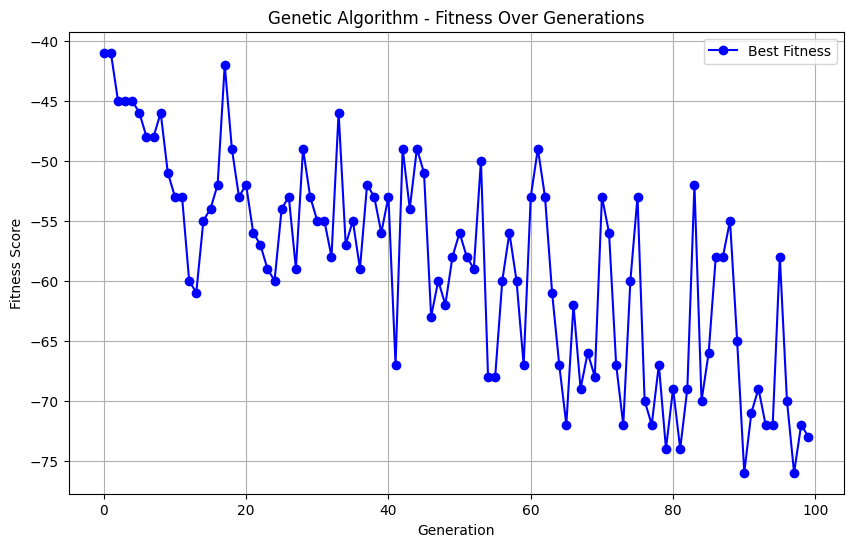

In [9]:
def kenkenG(pop_size, max_generations, grid_size, cages, pm):
    population = create_population(pop_size, grid_size)
    best_fitness_overall = None
    best_solution = None

    best_fitness_per_gen = []

    for i_gen in range(max_generations):
        fitness_values = evaluate_fitness(population, grid_size, cages)
        best_i = fitness_values.index(max(fitness_values))
        best_fitness = fitness_values[best_i]
        best_solution_gen = population[best_i]
        best_solution_gen = np.array(best_solution_gen)

        if best_fitness_overall is None or best_fitness > best_fitness_overall:
            best_fitness_overall = best_fitness
            best_solution = population[best_i]

        best_fitness_per_gen.append(best_fitness)

        print(f'i_gen = {i_gen:06}   Best fitness in population: {-best_fitness:03}')
        print(best_solution_gen)
        if best_fitness == 0:
            print('Found optimal solution')
            break

        selected_pop = selection(population, fitness_values)
        children = []

        for i in range(0, len(selected_pop), 2):
            if i + 1 < len(selected_pop):
                child1, child2 = crossover(selected_pop[i], selected_pop[i + 1])
                child1 = swap_mutate(child1, pm)
                child2 = swap_mutate(child2, pm)
                children.append(child1)
                children.append(child2)

        population = children

    print()
    print('Best solution:')
    print(best_solution)
    print('\r' + f' Best fitness={-best_fitness_overall:03}', end='')

    return best_solution, best_fitness_per_gen

cages = [
   ('+', 7, [(0, 0), (0, 1)]),
   ('*', 15, [(0, 2), (0, 3), (1, 2)]),
   ('*', 10, [(0, 4), (1, 4), (2,4)]),
   ('*', 4, [(1, 0), (2, 0)]),
   ('-', 2, [(1, 1), (2, 1)]),
   ('+', 9, [(1, 3), (2, 3), (3,3)]),
   ('-', 3, [(2, 2), (3, 2)]),
   ('/', 2, [(3, 0), (3, 1)]),
   ('*', 12, [(3, 4), (4, 4)]),
   ('+', 7, [(4, 0), (4, 1)]),
   ('-', 3, [(4, 2), (4, 3)])
]
best_solution, best_fitness_per_gen = kenkenG(pop_size=50, max_generations=100, grid_size=4, cages=cages, pm=0.1)

generations = list(range(len(best_fitness_per_gen)))
best_fitness = best_fitness_per_gen

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(generations, best_fitness, label='Best Fitness', color='blue', marker='o')
plt.xlabel('Generation')
plt.ylabel('Fitness Score')
plt.title('Genetic Algorithm - Fitness Over Generations')
plt.legend()
plt.grid(True)
plt.savefig('fitness_plot.png')
plt.show()


### 🔍 **Key Insights:**

1. **Fitness improves over generations** — the GA is learning and progressing.
2. **High fluctuations** indicate randomness (likely from mutation or diverse population).
3. **No convergence yet** — fitness still varies near generation 100.
4. **Early improvement is steep** — GA found better solutions quickly at the start.
5. **Occasional regressions** are normal — exploration can temporarily worsen fitness.
